Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

Begin Data Cleaning

In [2]:
# read file
df = pd.read_csv(r'C:\Users\krist\Downloads\SN_d_tot_V2.0.csv', sep=';')

In [3]:
# inspect data
df.head()

,1818,01,01.1,1818.001,-1,-1.0,0,1
0,1818,1,2,1818.004,-1,-1.0,0,1
1,1818,1,3,1818.007,-1,-1.0,0,1
2,1818,1,4,1818.010,-1,-1.0,0,1
3,1818,1,5,1818.012,-1,-1.0,0,1
4,1818,1,6,1818.015,-1,-1.0,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74629 entries, 0 to 74628
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   1818      74629 non-null  int64  
 1   01        74629 non-null  int64  
 2   01.1      74629 non-null  int64  
 3   1818.001  74629 non-null  float64
 4     -1      74629 non-null  int64  
 5    -1.0     74629 non-null  float64
 6      0      74629 non-null  int64  
 7   1         74629 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 4.6 MB


In [5]:
# check for duplicated rows
df[df.duplicated()]

,1818,01,01.1,1818.001,-1,-1.0,0,1


In [6]:
# check for missing values
df.isna().sum()

1818        0
01          0
01.1        0
1818.001    0
  -1        0
 -1.0       0
   0        0
1           0
dtype: int64

In [7]:
# clean column names
df.columns = df.columns.str.strip()
print(df.columns)

Index(['1818', '01', '01.1', '1818.001', '-1', '-1.0', '0', '1'], dtype='object')


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74629 entries, 0 to 74628
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   1818      74629 non-null  int64  
 1   01        74629 non-null  int64  
 2   01.1      74629 non-null  int64  
 3   1818.001  74629 non-null  float64
 4   -1        74629 non-null  int64  
 5   -1.0      74629 non-null  float64
 6   0         74629 non-null  int64  
 7   1         74629 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 4.6 MB


Prepare Data for Prophet

In [9]:
# combine Year, Month, and Day columns into a single Date column (ds for Prophet)
df['Date'] = pd.to_datetime(df[['1818', '01', '01.1']].astype(str).agg('-'.join, axis=1))

In [10]:
# prepare data 
df_prophet = df[['Date', '-1']].rename(columns={'Date': 'ds', '-1': 'y'})

In [11]:
# rename columns for prophet
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='coerce')

In [12]:
print(df_prophet.head())

          ds  y
0 1818-01-02 -1
1 1818-01-03 -1
2 1818-01-04 -1
3 1818-01-05 -1
4 1818-01-06 -1


Here, we lost the first row since that's what the file uses as the header, but I figured it's not a big deal since there wasn't a data entry for the total daily sunspot number there anyway.

Fit Model

In [13]:
# split data
train_size = int(len(df_prophet) * 0.8)
df_train = df_prophet[:train_size]
df_test = df_prophet[train_size:]

In [14]:
# make list for periods and frequencies
periods_list = [100, 200, 365]
freq_list = ['D', 'D', 'D']

In [15]:
# define function for forecasts
def forecast_sunspots(df_train, periods_list, freq_list):
    forecasts = {}
    # initialize and fit model
    model = Prophet()
    model.fit(df_train)
    # loop through periods and frequencies to generate forecasts
    for period, freq in zip(periods_list, freq_list):
        future = model.make_future_dataframe(periods=period, freq=freq)
        forecast = model.predict(future)
        forecast_future = forecast[forecast['ds'] > df_train['ds'].max()]
        forecasts[period] = forecast_future
    return forecasts

In [16]:
print(df_prophet.columns)

Index(['ds', 'y'], dtype='object')


In [17]:
# call functions for different periods
forecasts = forecast_sunspots(df_train, periods_list, freq_list)

22:54:24 - cmdstanpy - INFO - Chain [1] start processing
22:56:27 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
print(forecasts)

{100:               ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
59703 1981-06-19  97.493435   17.532125  190.433978    97.493435    97.493435   
59704 1981-06-20  97.490850   20.788001  183.177109    97.490850    97.490850   
59705 1981-06-21  97.488264   18.194320  189.339636    97.488264    97.488264   
59706 1981-06-22  97.485679   19.424199  189.134072    97.485679    97.485679   
59707 1981-06-23  97.483093   14.677257  186.425574    97.483093    97.483093   
...          ...        ...         ...         ...          ...          ...   
59798 1981-09-22  97.247818   11.606922  188.230665    97.247818    97.247818   
59799 1981-09-23  97.245232   20.369265  187.701838    97.245232    97.245232   
59800 1981-09-24  97.242647    5.660295  185.257837    97.242647    97.242647   
59801 1981-09-25  97.240061   10.131409  178.957492    97.240061    97.240061   
59802 1981-09-26  97.237476   13.780895  181.216292    97.237476    97.237476   

       additive_terms

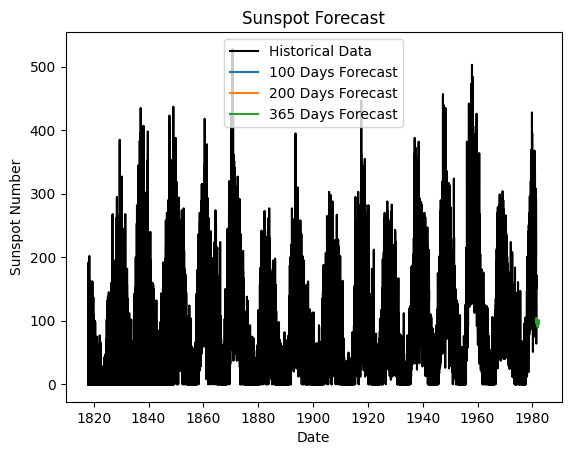

In [49]:
# plot both the historical data and the forecasts on one graph
# historical data
plt.plot(df_train['ds'], df_train['y'], label='Historical Data', color='black')
# loop forecasts
for period, forecast in forecasts.items():
    plt.plot(forecast['ds'], forecast['yhat'], label=f'{period} Days Forecast')
# plot forecasts
plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.title('Sunspot Forecast')
plt.legend()
# show the plot
plt.show()

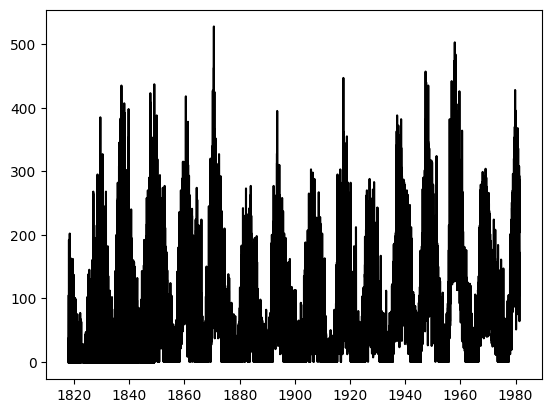

In [19]:
# plot historical data alone for comparison
plt.plot(df_train['ds'], df_train['y'], label='Historical Data', color='black')

In [20]:
# ensure that the forecasts are correctly formatted
for period, forecast in forecasts.items():
    print(f"Forecast for {period} days:")
    print(forecast[['ds', 'yhat']].head()) 

Forecast for 100 days:
              ds        yhat
59703 1981-06-19  100.895724
59704 1981-06-20  102.019600
59705 1981-06-21  101.981584
59706 1981-06-22  102.555513
59707 1981-06-23  102.703482
Forecast for 200 days:
              ds        yhat
59703 1981-06-19  100.895724
59704 1981-06-20  102.019600
59705 1981-06-21  101.981584
59706 1981-06-22  102.555513
59707 1981-06-23  102.703482
Forecast for 365 days:
              ds        yhat
59703 1981-06-19  100.895724
59704 1981-06-20  102.019600
59705 1981-06-21  101.981584
59706 1981-06-22  102.555513
59707 1981-06-23  102.703482


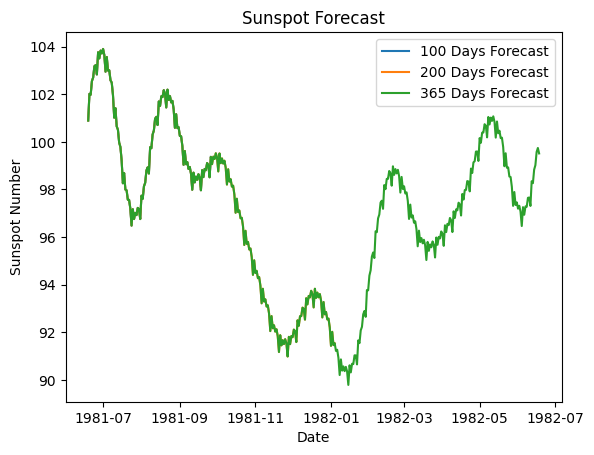

In [21]:
# plot forecasts for the three different periods
for period, forecast in forecasts.items():
    plt.plot(forecast['ds'], forecast['yhat'], label=f'{period} Days Forecast')

plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.title('Sunspot Forecast')
plt.legend()
plt.show()

Since I can't see the different lines, I plotted them separately to make sure they are all there.

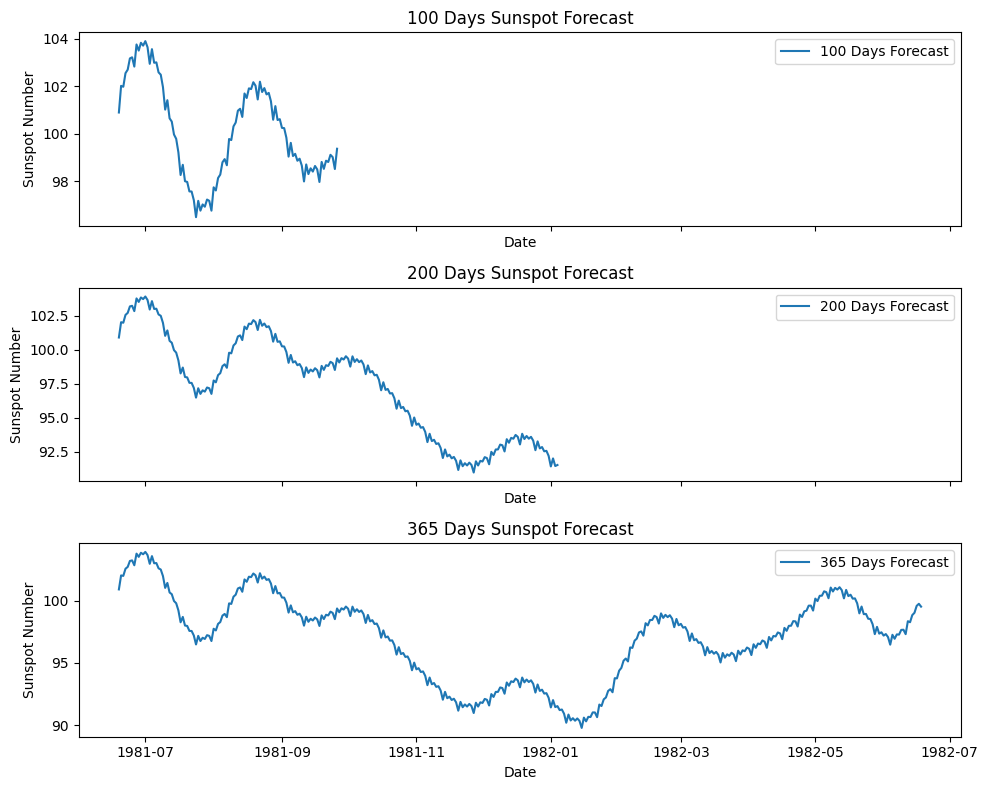

In [22]:
# create subplots
fig, axes = plt.subplots(len(forecasts), 1, figsize=(10, 8), sharex=True)

# plot each forecast in a different subplot
for ax, (period, forecast) in zip(axes, forecasts.items()):
    ax.plot(forecast['ds'], forecast['yhat'], label=f'{period} Days Forecast')
    ax.set_title(f'{period} Days Sunspot Forecast')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sunspot Number')
    ax.legend()

# adjust the layout to avoid overlap
plt.tight_layout()
plt.show()

Right off the bat, it strikes me as strange that the highest value in these graphs is barely 105 whereas the largest value in the historical data is over 500. Although there does seem to be some decrease towards the end of the historical data, the predicted values still seem to be undershot, so this is something I hope to remedy with the parameter tuning. 

Evaluate Model

In [23]:
# merge actual data and forecast
df_comparison = pd.merge(forecast[['ds', 'yhat']], df_prophet[['ds','y']], on='ds', how='inner')

In [48]:
print(df_comparison.head())

          ds       yhat  y
0 1975-12-28 -10.048903  0
1 1975-12-29  -6.175998  0
2 1975-12-30  -3.071714  0
3 1975-12-31   2.461824  0
4 1976-01-01   4.206775  0


In [24]:
# calculate MAE, MAPE, and R^2
mae = mean_absolute_error(df_comparison['y'], df_comparison['yhat'])
mape = mean_absolute_percentage_error(df_comparison['y'], df_comparison['yhat'])
r2 = r2_score(df_comparison['y'], df_comparison['yhat'])

In [25]:
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

MAE: 101.38719217244541
MAPE: 0.45933500618176026
R²: -2.1250060491280376


Based on my original model, my values were not great. My average of absolute differences between the predicted and actual values was about 101 which is poor. Upon reviewing the data, many of the actual values were 0, but my model would never predict that, so that could explain the discrepancy there. My average of absolute percentage errors is actually very good, but my R^2 which measures how well the model's predictions fit the actual data is less than one which is very bad which could possibly be due to the same issue as above. Hopefully, my parameter tuning can help improve this.

Tune the Model on Different Parameters

Forecasting Growth

For forecasting growth, I am using logistic growth because the data is going up and down over time, and there seems to be a cap. I chose my cap to be 600 since the maximum value in the historical seems to be a little over 500. My cells were taking a very long time to run, so I am going to reduce the amount of data for parameter tuning.

In [26]:
# reduce data
df_train_subset = df_train.tail(2000)

In [27]:
# create capacity column (upper limit)
df_train_subset['cap'] = 600

C:\Users\krist\AppData\Local\Temp\ipykernel_10136\1414714911.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_subset['cap'] = 600


In [28]:
# tune parameter
model = Prophet(growth='logistic')
model.fit(df_train_subset)

22:57:34 - cmdstanpy - INFO - Chain [1] start processing
22:57:35 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
# prepare dataframe for forecasting
future = model.make_future_dataframe(periods=365)

In [30]:
# add cap column
future['cap'] = 600

In [31]:
# make forecast
forecast = model.predict(future)

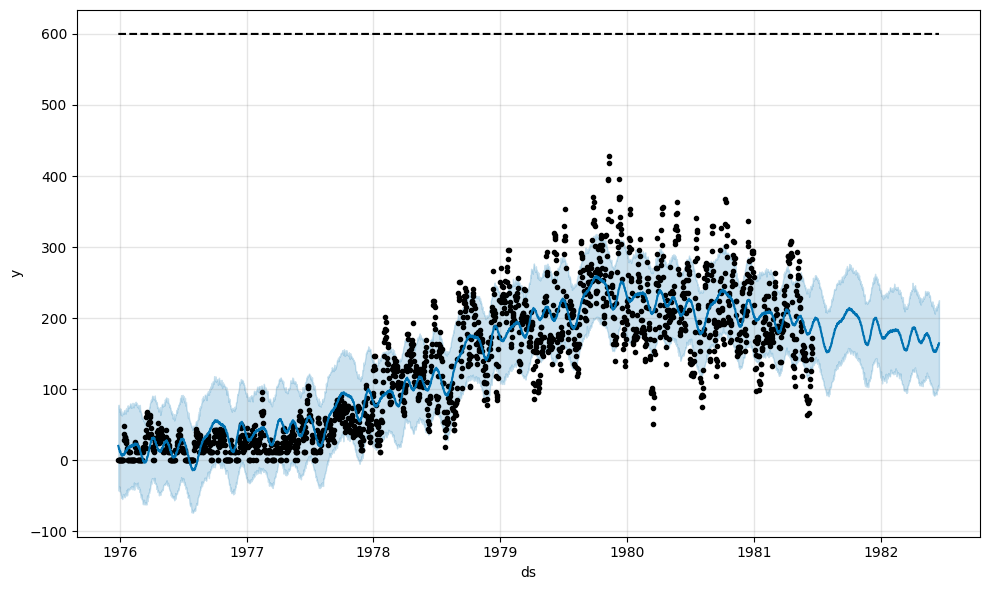

In [32]:
# plot
model.plot(forecast)
plt.show()

Here, the forecast definitely looks a bit more accurate to the historical data and seems to balancing out.

Seasonality

In [33]:
# add custom daily seasonality and a fourier order of 10
model = Prophet(growth='logistic')
model.add_seasonality(name='daily', period=365, fourier_order=10)
model.fit(df_train_subset)

22:57:45 - cmdstanpy - INFO - Chain [1] start processing
22:57:46 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
# prepare dataframe for forecasting
future = model.make_future_dataframe(periods=365)

In [35]:
# add cap column
future['cap'] = 600

In [36]:
# make forecast
forecast = model.predict(future)

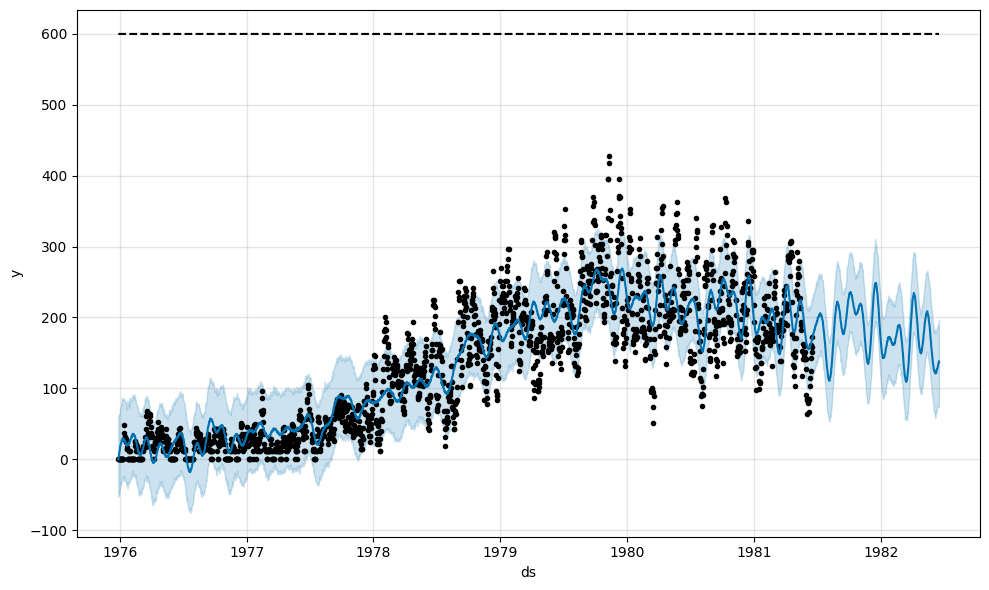

In [37]:
# plot
model.plot(forecast)
plt.show()

Again, I think my predictions look a little better and are more accurate to the historical data since they are remaining fairly steady.

Trend Changepoints

In [38]:
# add cap column
df_train_subset['cap'] = 600

C:\Users\krist\AppData\Local\Temp\ipykernel_10136\2277806749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_subset['cap'] = 600


In [39]:
# initialize model with tuning parameters
model = Prophet(
    growth='logistic',
    changepoint_prior_scale=0.5,
    n_changepoints=5)
model.add_seasonality(name='daily', period=365, fourier_order=10)

In [40]:
# fit the model
model.fit(df_train_subset)

22:57:56 - cmdstanpy - INFO - Chain [1] start processing
22:57:58 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
# prepare dataframe for forecasting
future = model.make_future_dataframe(periods=365)

In [42]:
# add cap column
future['cap'] = 600

In [43]:
# make forecast
forecast = model.predict(future)

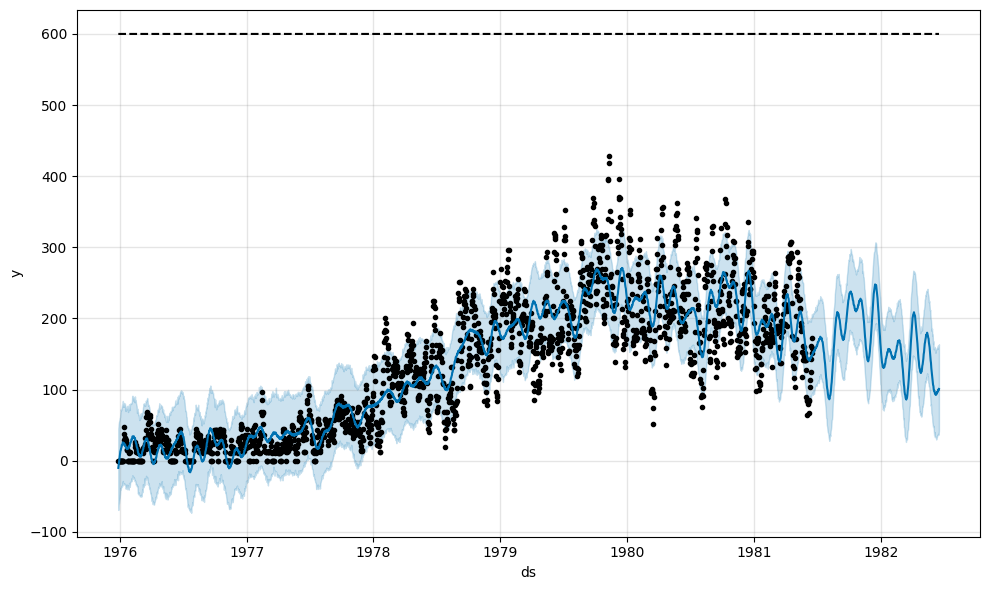

In [44]:
# plot
model.plot(forecast)
plt.show()

Once again, the data still looks steady, so I will now find the error rates for my new model.

Evaluate Model

In [45]:
# merge actual data and forecast
df_comparison = pd.merge(forecast[['ds', 'yhat']], df_prophet[['ds','y']], on='ds', how='inner')

In [46]:
# calculate MAE, MAPE, and R^2
mae = mean_absolute_error(df_comparison['y'], df_comparison['yhat'])
mape = mean_absolute_percentage_error(df_comparison['y'], df_comparison['yhat'])
r2 = r2_score(df_comparison['y'], df_comparison['yhat'])

In [47]:
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

MAE: 37.528455438771324
MAPE: 4700377516478742.0
R²: 0.720964587973992


After running my new model many times with different inputs for each of the parameters, this was the best outcome I could get. Even though my MAE and R^2 improved drastically, my MAPE got so much worse that I wonder how it is even possible. I decided that I would settle for the MAE and R^2 improving for now, but this is definitely something I want to investigate more in the future. 